<a href="https://colab.research.google.com/github/arifsoul/DIS-2/blob/Arif/DIS_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers.experimental.preprocessing import RandomContrast, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.backend import clear_session
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from skimage.transform import resize
import imgaug.augmenters as iaa
import cv2

batch_size = 32
size_img = (100, 100, 3)

#Prepare dataset


In [8]:
path_dataset = '/content/drive/MyDrive/clean_BISINDO'
# folders = sorted(os.listdir(path_dataset))
# folders = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'NOTHING']
folders = ['O', 'S', 'NOTHING']
print(folders)

['O', 'S', 'NOTHING']


In [9]:
dataset_collection = []
target = []
classes = []

cls_count = 0
print('ID\tSample\t\tName')
for folder in folders:
    dir = os.path.join(path_dataset, folder)
    filename = os.listdir(dir)
    count_img = 0

    if len(filename) > 0:
        for f in filename:
            if f != ".ipynb_checkpoints":
              img_path =  os.path.join(dir, f)  
              dataset_collection.append(img_path)
              target.append(cls_count)
              count_img += 1 

        print('{}\t{} sample\t{}'.format(cls_count, count_img, folder))
        classes.append(folder)
        cls_count += 1

print('\nTotal:\t{} sample'.format(len(dataset_collection)))

ID	Sample		Name
0	3 sample	O
1	3 sample	S
2	3 sample	NOTHING

Total:	9 sample


In [10]:
dataset_collection

['/content/drive/MyDrive/clean_BISINDO/O/wall white (1).jpg',
 '/content/drive/MyDrive/clean_BISINDO/O/body white (1).jpg',
 '/content/drive/MyDrive/clean_BISINDO/O/body dot (1).jpg',
 '/content/drive/MyDrive/clean_BISINDO/S/body dot (1).jpg',
 '/content/drive/MyDrive/clean_BISINDO/S/wall white (1).jpg',
 '/content/drive/MyDrive/clean_BISINDO/S/body white (1).jpg',
 '/content/drive/MyDrive/clean_BISINDO/NOTHING/IMG_0945.JPG',
 '/content/drive/MyDrive/clean_BISINDO/NOTHING/IMG_0960.JPG',
 '/content/drive/MyDrive/clean_BISINDO/NOTHING/IMG_0947.JPG']

In [11]:
all_data = []
labels = []
count = 0

for img_path, label in zip(dataset_collection, target):
    print(count)
    orig_img = cv2.imread(img_path)
    seq_aug = [
        None,
        iaa.Affine(rotate=10),
        iaa.Affine(rotate=-10),
        iaa.Affine(rotate=20),
        iaa.Affine(rotate=-20),
        iaa.Affine(rotate=30),
        iaa.Affine(rotate=-30),
        iaa.LinearContrast((0.75, 1.5)),
        iaa.Sometimes(0.5,iaa.GaussianBlur(sigma=(0, 0.5))),
        iaa.Fliplr(0.5), # horizontal flips
        iaa.Crop(percent=(0, 0.1)), # random crops
        iaa.Multiply((0.8, 1.2), per_channel=0.2),
        iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
    ]

    for aug in seq_aug:
        img = orig_img.copy()
        if aug != None:
            img = aug(image=img)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        img = resize(img, size_img)
        all_data.append(img)
        labels.append(label)
    count += 1

print('All Training:', len(all_data))

0
1
2
3
4
5
6
7
8
All Training: 117


#Split Train, Val, Test

In [12]:
numpy_dir = "/content/drive/MyDrive/numpy_dis_2/"
if not os.path.exists(numpy_dir):
  os.mkdir(numpy_dir)

In [13]:
np.save(numpy_dir+"all_data_100.npy", all_data)
np.save(numpy_dir+"labels_100.npy", labels)

In [14]:
all_data = np.load(numpy_dir+"all_data_100.npy")
labels = np.load(numpy_dir+"labels_100.npy")

In [15]:
# classes_folder = sorted(os.listdir('/content/drive/MyDrive/Citra BISINDO'))
classes_folder = ['O', 'S', 'NOTHING']
# classes_folder = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'NOTHING']
print(classes_folder)

['O', 'S', 'NOTHING']


In [16]:
X_train, X_test, y_train, y_test = train_test_split(all_data, labels, test_size=0.3, random_state=42, stratify=labels)
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)
X_test, X_val, y_test, y_val = np.array(X_test), np.array(X_val), np.array(y_test), np.array(y_val)

print('ID\tData Train\tData Val\tData Test\tName')
for i in range(len(classes_folder)):
    count_train, count_val, count_test = len(np.where(y_train==i)[0]), len(np.where(y_val==i)[0]), len(np.where(y_test==i)[0])
    print('{}\t{} sample\t{} sample\t{} sample\t{}'.format(i, count_train, count_val, count_test, classes_folder[i]))
print('\nTotal:\t {} sample\t {} sample\t {} sample'.format(len(y_train), len(y_val), len(y_test)))

ID	Data Train	Data Val	Data Test	Name
0	27 sample	6 sample	6 sample	O
1	27 sample	6 sample	6 sample	S
2	27 sample	6 sample	6 sample	NOTHING

Total:	 81 sample	 18 sample	 18 sample


In [17]:
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

print(y_train_cat[0])
print(y_val_cat[0])
print(y_test_cat[0])

[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]


## Machine Learning


In [19]:
num_label = len(y_train_cat[0])
print(f'Jumlah class = {len(y_train_cat[0])}')

Jumlah class = 3


In [20]:
clear_session()

# Transfer Learning
model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(size_img),
    pooling='avg',
    classes=num_label,
    classifier_activation="softmax")

fc = Dense(1024, activation='relu')(model.layers[-1].output)
fc2 = Dense(512, activation='relu')(fc)
fc3 = Dense(256, activation='relu')(fc2)
fc4 = Dropout(0.2)(fc3)
output = Dense(num_label, activation='softmax')(fc4)

model = tf.keras.Model(inputs=model.inputs, outputs=output)
model.compile(optimizer= Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [ ]:
# Data Augmentation

data_augmentation = Sequential()
data_augmentation.add(RandomFlip("horizontal", input_shape=size_img))
data_augmentation.add(RandomZoom(0.1))
data_augmentation.add(RandomContrast(0.2))


In [ ]:
# Create Model
# model = Sequential()
# model.add(data_augmentation)
# model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',input_shape=size_img))
# model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.4))
# model.add(Dense(num_label, activation='softmax'))

# clear_session()
# model.summary()

In [21]:
#early stopping to monitor the validation accuracy and avoid overfitting
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)

#autosave best model
model_best = ModelCheckpoint(filepath='/content/drive/MyDrive/Model_dis_2/Model-best-new.h5',
                                   monitor='val_loss',
                                   save_best_only=True)
#model compiling
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
epochs=20
batch_size=16
history = model.fit(X_train, y_train_cat, epochs=epochs, validation_data=(X_val, y_val_cat), batch_size=batch_size, callbacks = [rlrop, model_best],verbose = 1)

Epoch 1/20
6/6 [==============================] - 10s 703ms/step - loss: 5.6362 - accuracy: 0.3457 - val_loss: 1.0935 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/20
6/6 [==============================] - 0s 74ms/step - loss: 1.1356 - accuracy: 0.2963 - val_loss: 1.0999 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/20
6/6 [==============================] - 0s 63ms/step - loss: 1.1070 - accuracy: 0.2840 - val_loss: 1.0991 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 4/20
6/6 [==============================] - 0s 63ms/step - loss: 1.1046 - accuracy: 0.3333 - val_loss: 1.0994 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 5/20
6/6 [==============================] - 0s 61ms/step - loss: 1.1015 - accuracy: 0.3333 - val_loss: 1.0992 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 6/20
5/6 [========================>.....] - ETA: 0s - loss: 1.0985 - accuracy: 0.3375
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 [==============================] - 0s 64ms/step - loss: 1.0983 - a

In [ ]:
# Compiling
# model.compile(optimizer=optimizer,loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [ ]:
# Train Model
# epochs=10
# history = model.fit(X_train, y_train_cat, epochs=epochs, validation_data=(X_val, y_val_cat))

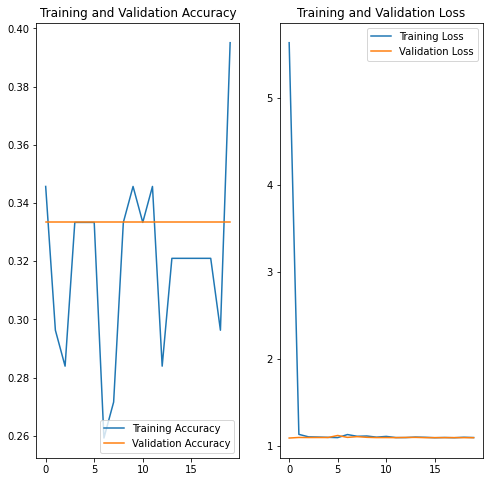

In [23]:
# Visualization
model = tf.keras.models.load_model('/content/drive/MyDrive/Model_dis_2/Model-best-new.h5')
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
# Evaluation
p_pred = model.predict(X_test)
y_pred = np.where(p_pred > 0.5, 1, 0)

cr = classification_report(y_test_cat, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         6

   micro avg       0.00      0.00      0.00        18
   macro avg       0.00      0.00      0.00        18
weighted avg       0.00      0.00      0.00        18
 samples avg       0.00      0.00      0.00        18



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
score = model.evaluate(X_test, y_test_cat, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.002822387730702758
Test accuracy: 1.0


In [20]:
X_test.shape


(54, 224, 224, 3)

In [47]:
print(classes[i])
np.argmax(classes[i][0])

[1.0000000e+00 3.6335841e-09 6.9203824e-30]


0

In [43]:
dirpath = '/content/drive/MyDrive/Citra BISINDO/O/body dot (2).jpg'
name_class = ['O','S','NOTHING']

model = tf.keras.models.load_model('/content/drive/MyDrive/Model_dis_2/Model-best.h5')

img = tf.keras.utils.load_img(
    dirpath, target_size=(100, 100)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(name_class[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to NOTHING with a 55.77 percent confidence.


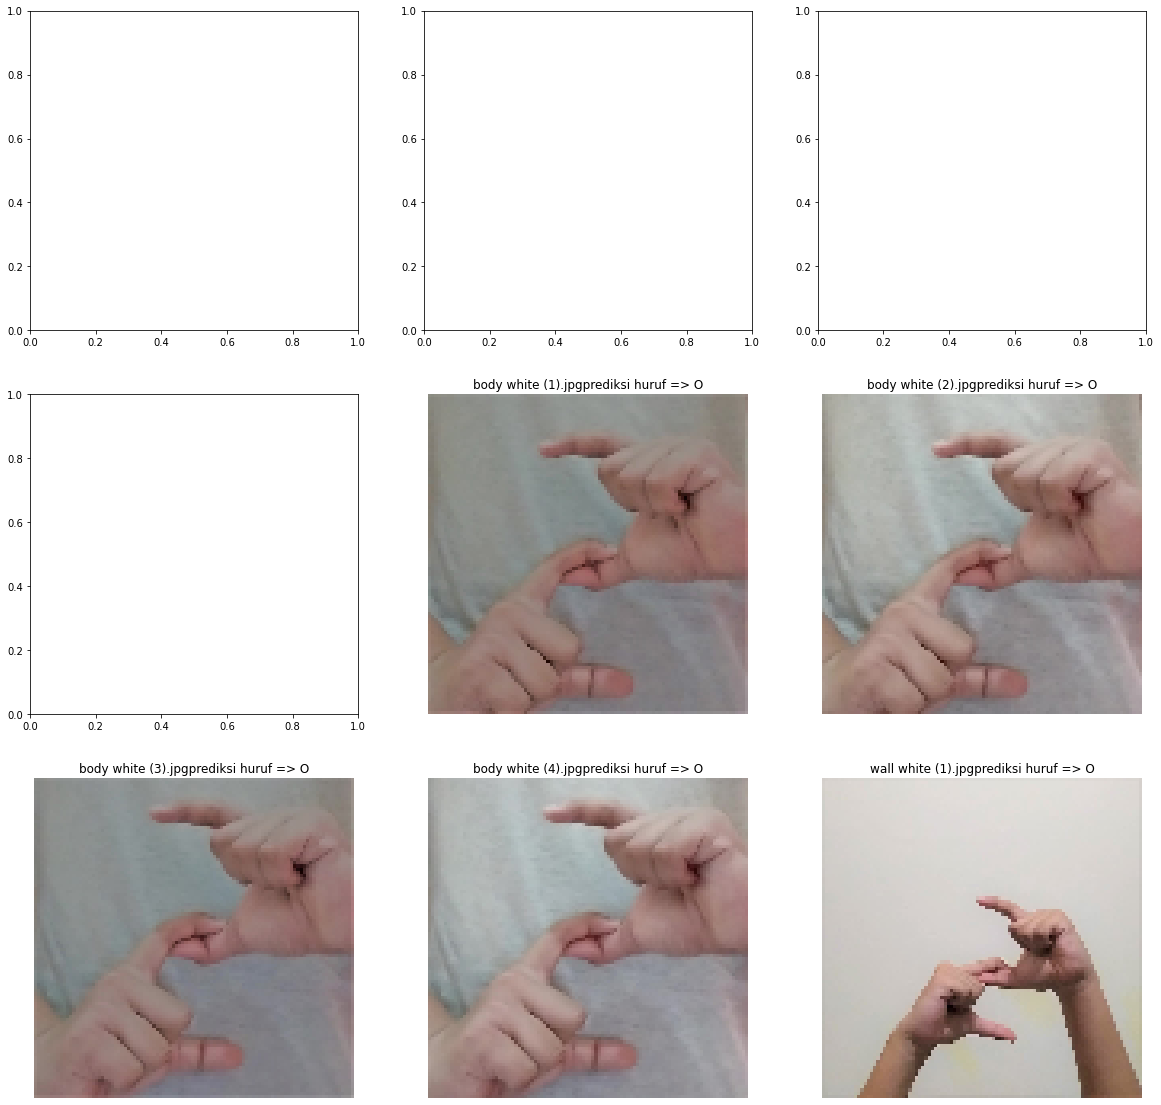

In [45]:
# Test image in folder 'test'
from keras.preprocessing import image
import numpy as np
import os
directory = '/content/drive/MyDrive/Citra BISINDO/S'
name_class = ['O','S','NOTHING']
image_name = []
images = []
collect_img = []
count_img = 9
list_file = sorted(os.listdir(directory))
model = tf.keras.models.load_model('/content/drive/MyDrive/Model_dis_2/Model-best.h5')

for img in list_file[:count_img]:
    image_name.append(img)
    img = os.path.join(directory, img)
    img = image.load_img(img, target_size=(size_img))
    img_np = image.img_to_array(img)
    img = np.expand_dims(img_np, axis=0)
    images.append(img)
    collect_img.append(img_np)

images = np.vstack(images)
classes = model.predict(images)

plt.figure(figsize=(20, 20))
for i in range(len(list_file[:count_img][:count_img])):
    idX_class = classes[i]
    ax = plt.subplot(3, 3, i + 1)

    if idX_class[0] == 1:
      # print(i+1, image_name[i],'    ', name_class[0])
      plt.imshow(collect_img[i].astype("uint8"))
      plt.title(image_name[i]+'prediksi huruf => '+name_class[0])
      plt.axis("off")

    elif idX_class[1] == 1:
      # print(i+1, image_name[i],'    ', name_class[1])
      plt.imshow(collect_img[i].astype("uint8"))
      plt.title(image_name[i]+'prediksi huruf => '+name_class[1])
      plt.axis("off")
      
    elif idX_class[2] == 1:
      # print(i+1, image_name[i],'    ', name_class[2])
      plt.imshow(collect_img[i].astype("uint8"))
      plt.title(image_name[i]+'prediksi huruf => '+name_class[2])
      plt.axis("off")

# Camera Acces

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
import html
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io

In [ ]:
def jsob_to_image(js_object):
  # decode base64 image
  image_bytes = b64decode(js_object.split(',')[1])
  # convert bytes to numpy array
  img_array = np.frombuffer(image_bytes, dtype=np.uint8)
  # convert numpy array into OpenCV BGR 
  frame = cv2.imdecode(img_array, flags=1)

  return frame

In [ ]:
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);
      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="blue: red; font-weight: bold;">' +
          'click here to stop the video</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();
      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; 
      captureCanvas.height = 480; 
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame() {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
  
            
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame():
  data = eval_js('stream_frame()')
  return data

# Get the webcam stream and forward it to python 
video_stream()

while True:
    frame_js = video_frame()
    if not frame_js:
        break
    img = jsob_to_image(frame_js["img"])

In [ ]:
# Get the webcam stream and forward it to python 
video_stream()

while True:
    frame_js = video_frame()
    if not frame_js:
        break
    img = jsob_to_image(frame_js["img"])